In [1]:
import torch
torch.cuda.is_available()

True

In [1]:
import numpy as np
from darts import TimeSeries
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.models import NaiveSeasonal
from darts.metrics import rmse, coefficient_of_variation, mape
from darts.models import *
import logging
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from datetime import datetime
from meteostat import Point, Hourly, Stations

import warnings

warnings.filterwarnings("ignore")

/home/jhoffbauer/hpi-porsche-challenge/.venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
SEED = 42

In [33]:
stations = Stations()
stations = stations.region('DE')
stations_list = stations.fetch(sample=True)
stations_list = stations_list.query('name in ["Düsseldorf", "München", "Bremen", "Greifswald", "Leipzig"]')

start = datetime(2015, 1, 1)
end = datetime(2023, 11, 17)

weather_data = Hourly(stations_list, start, end)
weather_data = weather_data.normalize() 
weather_data = weather_data.aggregate('1H', spatial=True)	
weather_data = weather_data.fetch()

weather_data.to_csv('weather_data_20150101_to_2023_11_17_short_list_stations.csv')

weather_data = TimeSeries.from_dataframe(weather_data, value_cols=list(weather_data.columns), fill_missing_dates=True, fillna_value=0, freq='1H')

In [34]:
data = pd.read_parquet("time-series-model/data/processed/energy_data_processed.parquet")
data.set_index("timestamp", inplace=True)
data = data[data.columns].astype(float)
series = TimeSeries.from_dataframe(data, fill_missing_dates=True, fillna_value=0)

data_scaler = Scaler()
series = data_scaler.fit_transform(series)

test_split = 0.15
val_split=0.15
train_end_index = (1 - val_split - test_split) * len(series)
val_end_index = (1 - test_split) * len(series)
train_end_index, val_end_index = int(train_end_index), int(val_end_index)

print(train_end_index, val_end_index)

train, val, test = series[:train_end_index], series[train_end_index:val_end_index], series[val_end_index:]

50585 61425


In [35]:
# Cut train to start of weather data
train = train[weather_data.start_time():]

print("Train size: ", len(train))
print("Val size: ", len(val))
print("Test size: ", len(test))

Train size:  50585
Val size:  10840
Test size:  10840


Number of components is larger than 10 (12). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


Text(0.5, 1.0, 'Data')

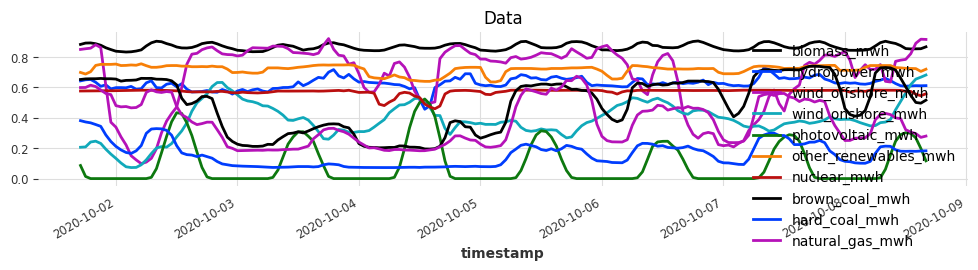

In [36]:
plt.figure(figsize=(12,2))
train[-24*7:].plot()
plt.title("Data")

Text(0.5, 1.0, 'Covariates Time')

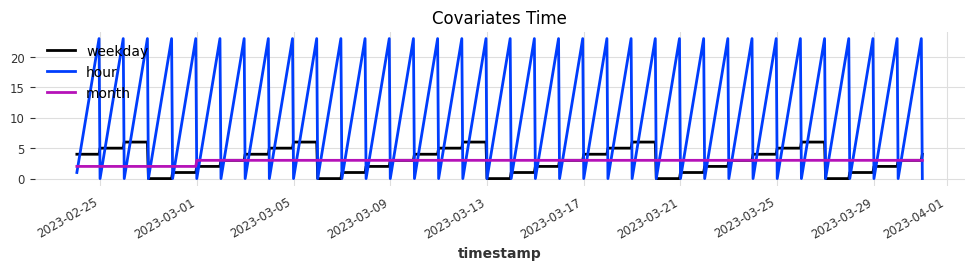

In [37]:
weekday = datetime_attribute_timeseries(series, attribute="weekday")
month = datetime_attribute_timeseries(series, attribute="month")
hour = datetime_attribute_timeseries(series, attribute="hour")
covariates_time = weekday.stack(hour).stack(month)

scaler_covariates = Scaler()
covariates = scaler_covariates.fit_transform(
    covariates_time
)

plt.figure(figsize=(12,2))
covariates_time[-5*7*24:].plot()
plt.title("Covariates Time")

In [12]:
def get_covariate_args(model, include_weather):

    covariates = covariates_time

    if include_weather:
        covariates = covariates.stack(weather_data)

    covariate_args = {}
    covariate_args_inference = {}
    if model.supports_past_covariates:
        covariate_args['past_covariates'] = covariates
        covariate_args['val_past_covariates'] = covariates
        covariate_args_inference['past_covariates'] = covariates
    if model.supports_future_covariates:
        covariate_args['future_covariates'] = covariates
        covariate_args['val_future_covariates'] = covariates
        covariate_args_inference['future_covariates'] = covariates

    return covariate_args, covariate_args_inference


def fit_model(model, include_weather):
    covariate_args = get_covariate_args(model, include_weather=include_weather)[0]
    model.fit(series=train, val_series=val, **covariate_args)
    

lstm_model_no_weather = RNNModel(model="LSTM", input_chunk_length=24*7, training_length=24*7*4, hidden_dim=16, dropout=0.2, n_rnn_layers=1, n_epochs=5, force_reset=True)
lstm_model_with_weather = RNNModel(model="LSTM", input_chunk_length=24*7, training_length=24*7*4, hidden_dim=16, dropout=0.2, n_rnn_layers=1, n_epochs=5, force_reset=True)
fit_model(lstm_model_no_weather, include_weather=False)
fit_model(lstm_model_no_weather, include_weather=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.1 K 
4 | V             | Linear           | 204   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3

Epoch 4: 100%|██████████| 1560/1560 [01:17<00:00, 20.10it/s, train_loss=0.000685, val_loss=0.000744]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1560/1560 [01:17<00:00, 20.10it/s, train_loss=0.000685, val_loss=0.000744]


In [16]:
lstm_model_no_weather.save("time-series-model/models/lstm_model_preliminary_no_weather.pkl")
lstm_model_with_weather.save("time-series-model/models/lstm_model_preliminary_with_weather.pkl")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]
model RNNModel(model=LSTM, hidden_dim=16, dropout=0.2, training_length=672, input_chunk_length=168, n_epochs=5, force_reset=True)
  test rmse 0.17011544449907381
  test cov 63.21246101959279


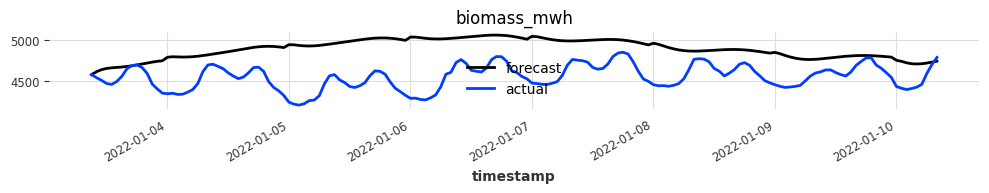

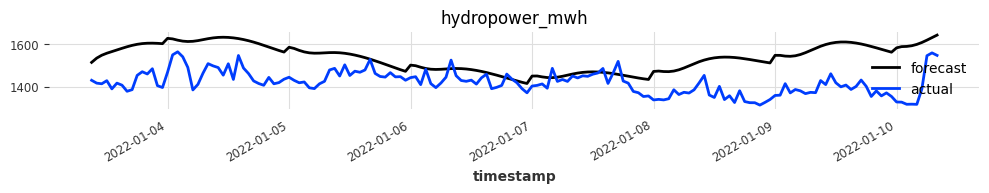

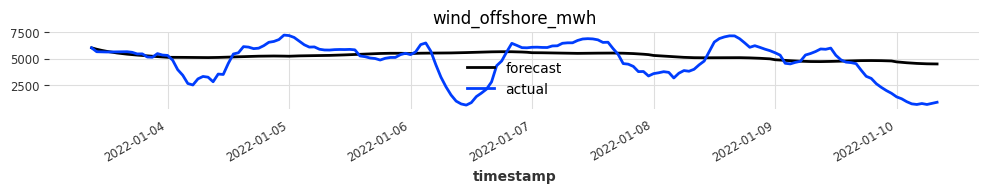

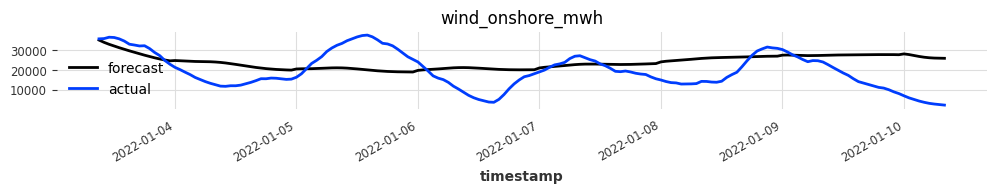

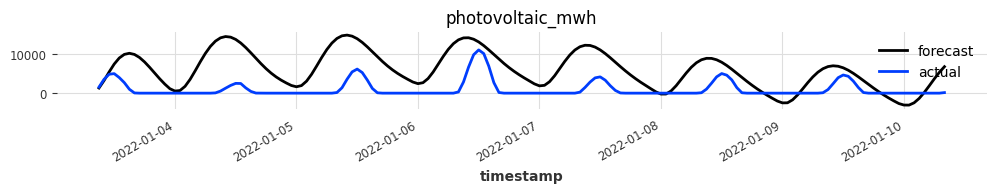

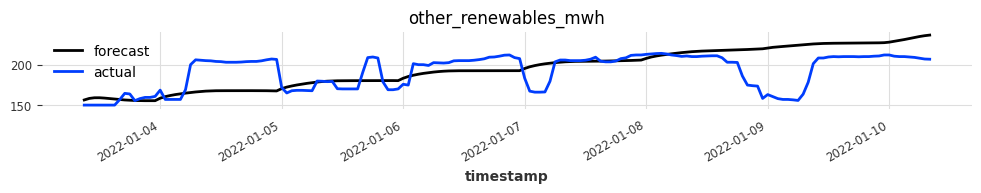

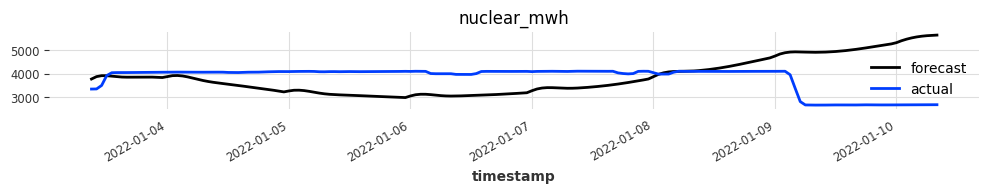

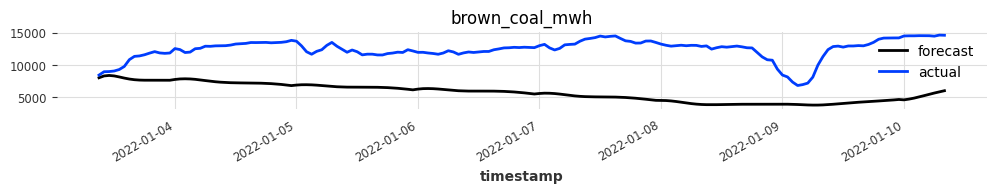

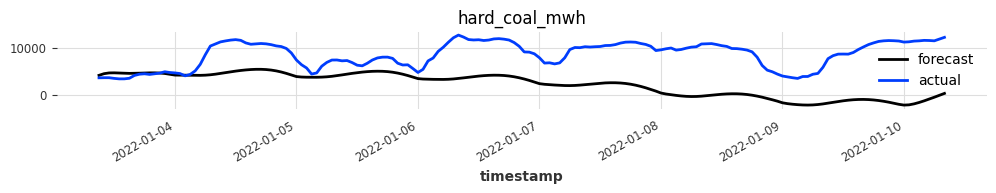

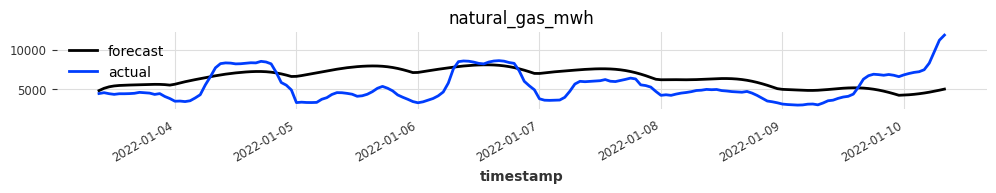

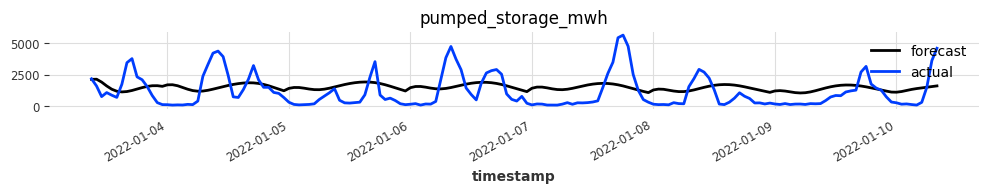

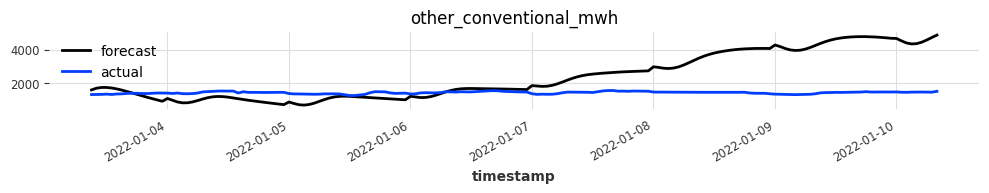

In [14]:
TEST_N_STEPS_AHEAD = 7 * 24

def eval_model(model, include_weather):
    
    _, covariate_args_inference = get_covariate_args(model, include_weather=include_weather)
    forecast = model.predict(TEST_N_STEPS_AHEAD, series=val, **covariate_args_inference)

    forecaset_rescaled = data_scaler.inverse_transform(forecast[:TEST_N_STEPS_AHEAD])
    test_rescaled = data_scaler.inverse_transform(test[:TEST_N_STEPS_AHEAD])
    
    test_rmse = rmse(test_rescaled, forecaset_rescaled)
    test_cov = coefficient_of_variation(test_rescaled, forecaset_rescaled)
    #test_mape = mape(test, forecast)
    print(f"model {model}")
    print(f"  test rmse {test_rmse}")
    print(f"  test coeff of variation {test_cov}")
    #print(f"  test mape {test_mape}")
    

    for col in forecaset_rescaled.columns:
        plt.figure(figsize=(12, 1))
        forecaset_rescaled[col].plot(label="forecast")
        test_rescaled[col].plot(label="actual")
        plt.title(col)
        plt.show()

    # plt.figure()
    # forecaset_rescaled.plot()
    # test_rescaled.plot()
    # plt.title(str(model))
    # plt.show()

eval_model(lstm_model_no_weather, include_weather=False)
eval_model(lstm_model_with_weather, include_weather=True)